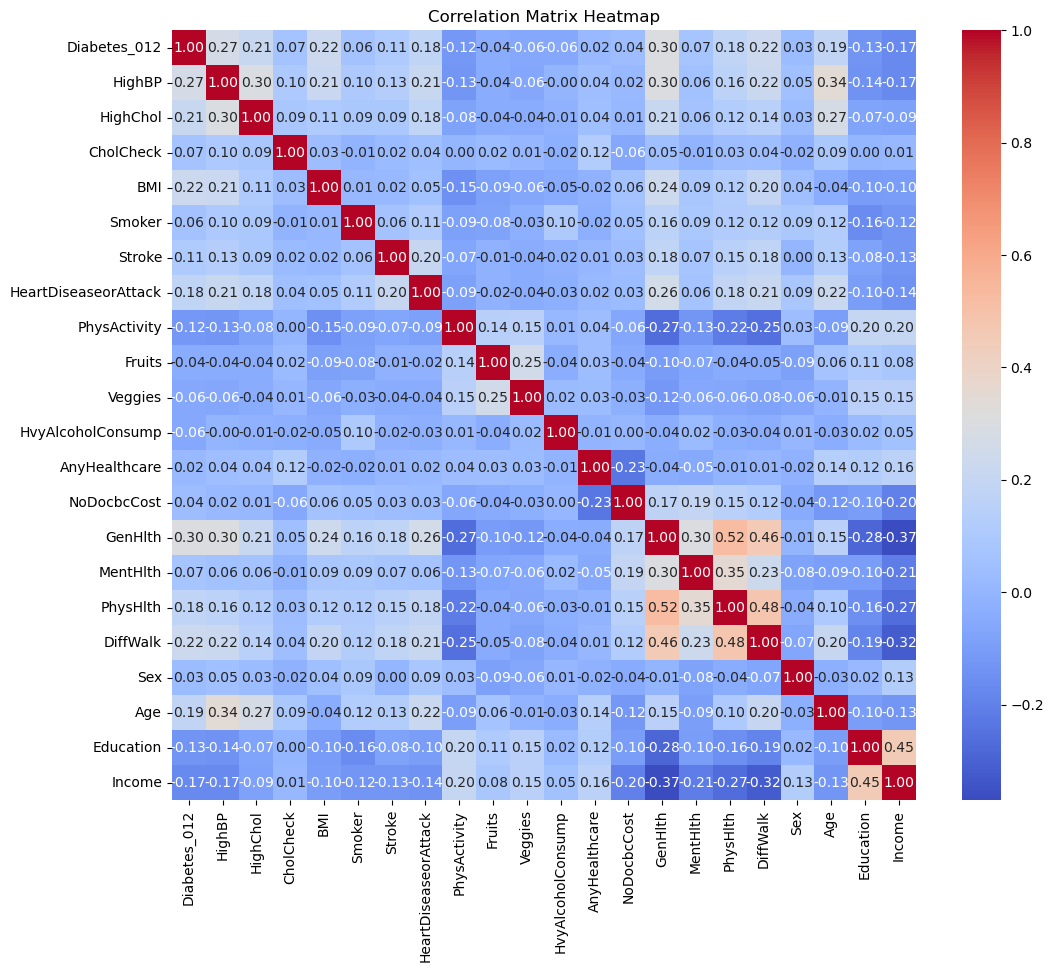

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))  # Optional: Make plot bigger for readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

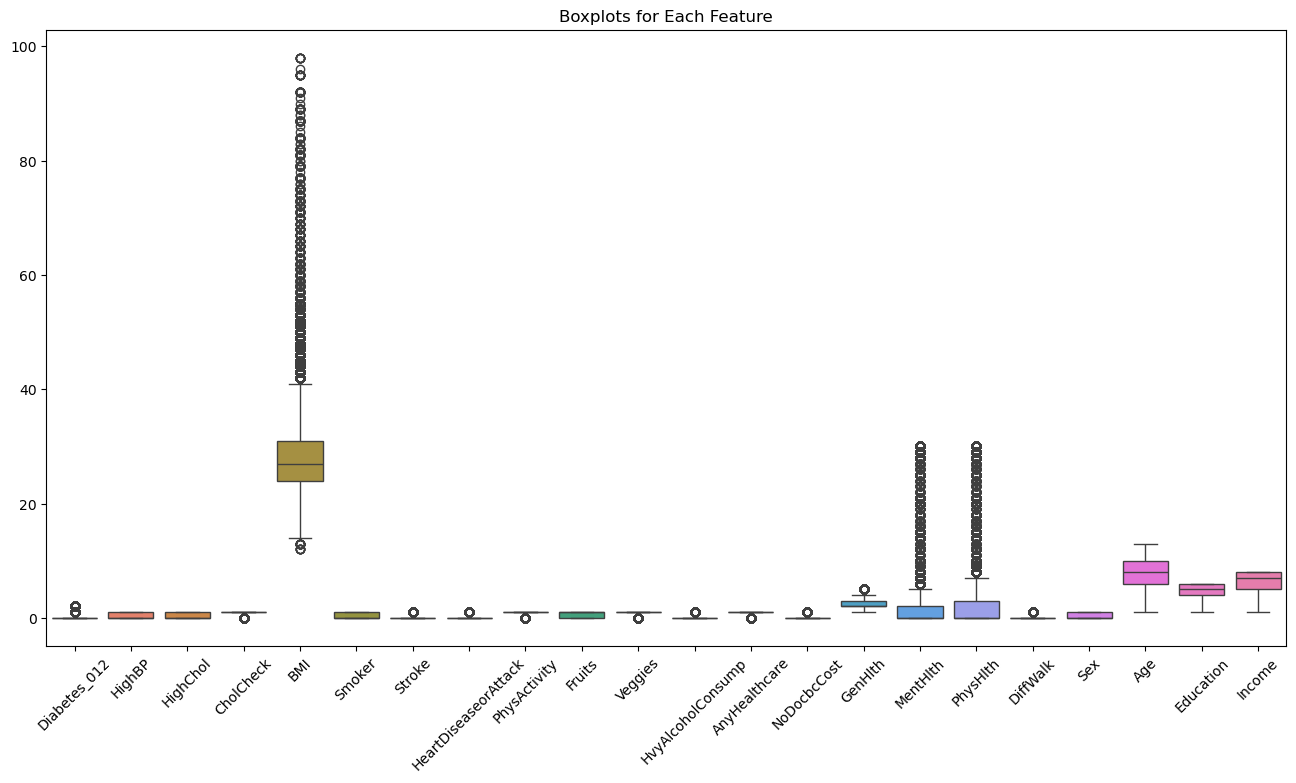

In [7]:
# Plot boxplots
plt.figure(figsize=(16, 8))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title('Boxplots for Each Feature')
plt.show()


In [8]:
# Step 1: Identify binary and continuous columns
binary_cols = [col for col in df.columns if sorted(df[col].dropna().unique()) == [0, 1]]
continuous_cols = [col for col in df.columns if col not in binary_cols and col != 'Diabetes_012']
print("Binary columns:", binary_cols)
print("Continuous columns:", continuous_cols)

# Step 2: Calculate Q1, Q2, Q3, IQR only for continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q2 = df[continuous_cols].quantile(0.50)  # Median
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

print("\nQ1:\n", Q1)
print("\nQ2 (Median):\n", Q2)
print("\nQ3:\n", Q3)
print("\nIQR:\n", IQR)

# Step 3: Remove outliers for continuous columns only
# (Binary columns are untouched)
filter_condition = ~((df[continuous_cols] < (Q1 - IQR)) | (df[continuous_cols] > (Q3 + IQR))).any(axis=1)
df_clean = df[filter_condition]


print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


Binary columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
Continuous columns: ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Q1:
 BMI          24.0
GenHlth       2.0
MentHlth      0.0
PhysHlth      0.0
Age           6.0
Education     4.0
Income        5.0
Name: 0.25, dtype: float64

Q2 (Median):
 BMI          27.0
GenHlth       2.0
MentHlth      0.0
PhysHlth      0.0
Age           8.0
Education     5.0
Income        7.0
Name: 0.5, dtype: float64

Q3:
 BMI          31.0
GenHlth       3.0
MentHlth      2.0
PhysHlth      3.0
Age          10.0
Education     6.0
Income        8.0
Name: 0.75, dtype: float64

IQR:
 BMI          7.0
GenHlth      1.0
MentHlth     2.0
PhysHlth     3.0
Age          4.0
Education    2.0
Income       3.0
dtype: float64

Original shape: (253680, 22)
Cleaned shape: (164444, 22)


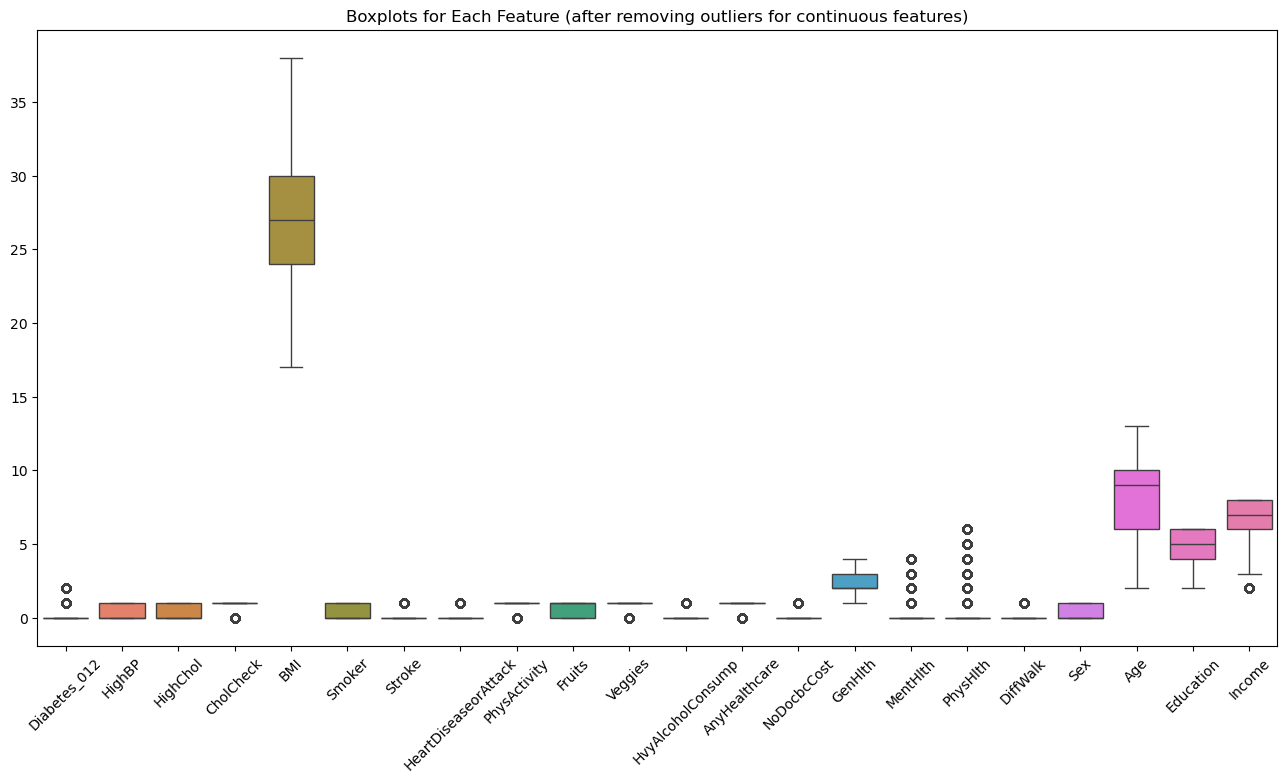

In [9]:
# Plot boxplots
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_clean)
plt.xticks(rotation=45)
plt.title('Boxplots for Each Feature (after removing outliers for continuous features)')
plt.show()

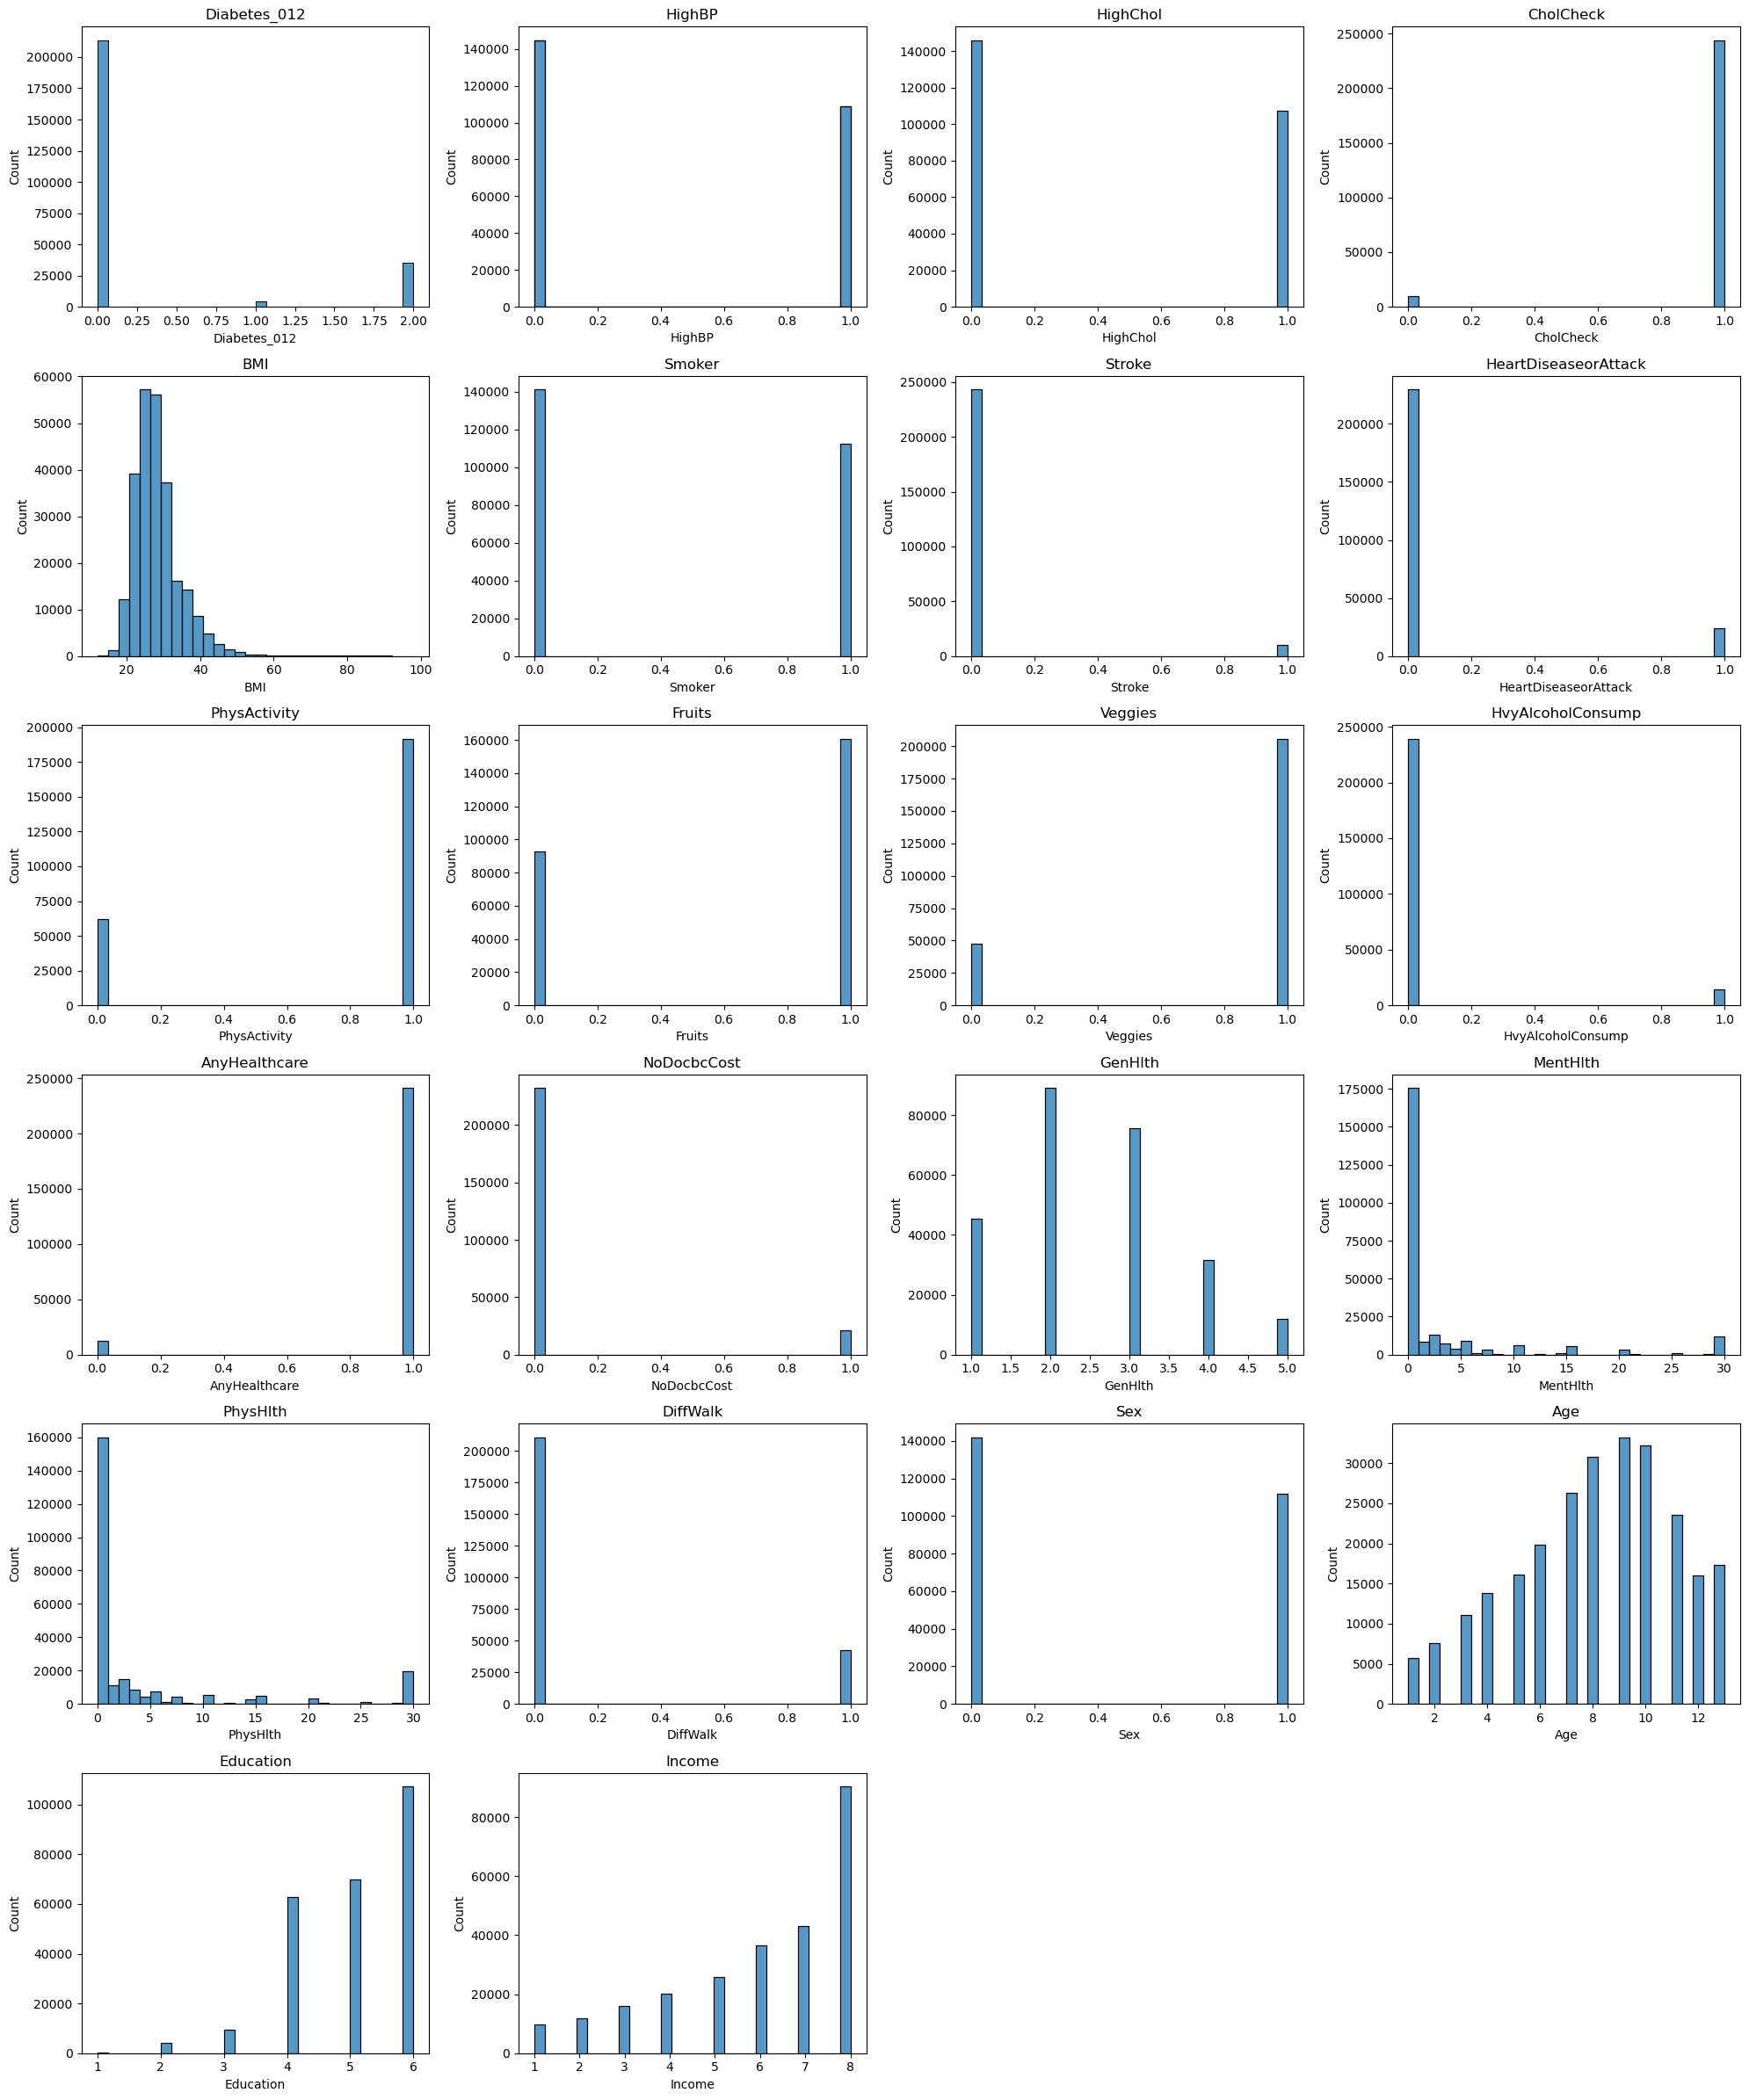

In [10]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    plt.tight_layout()

plt.show()


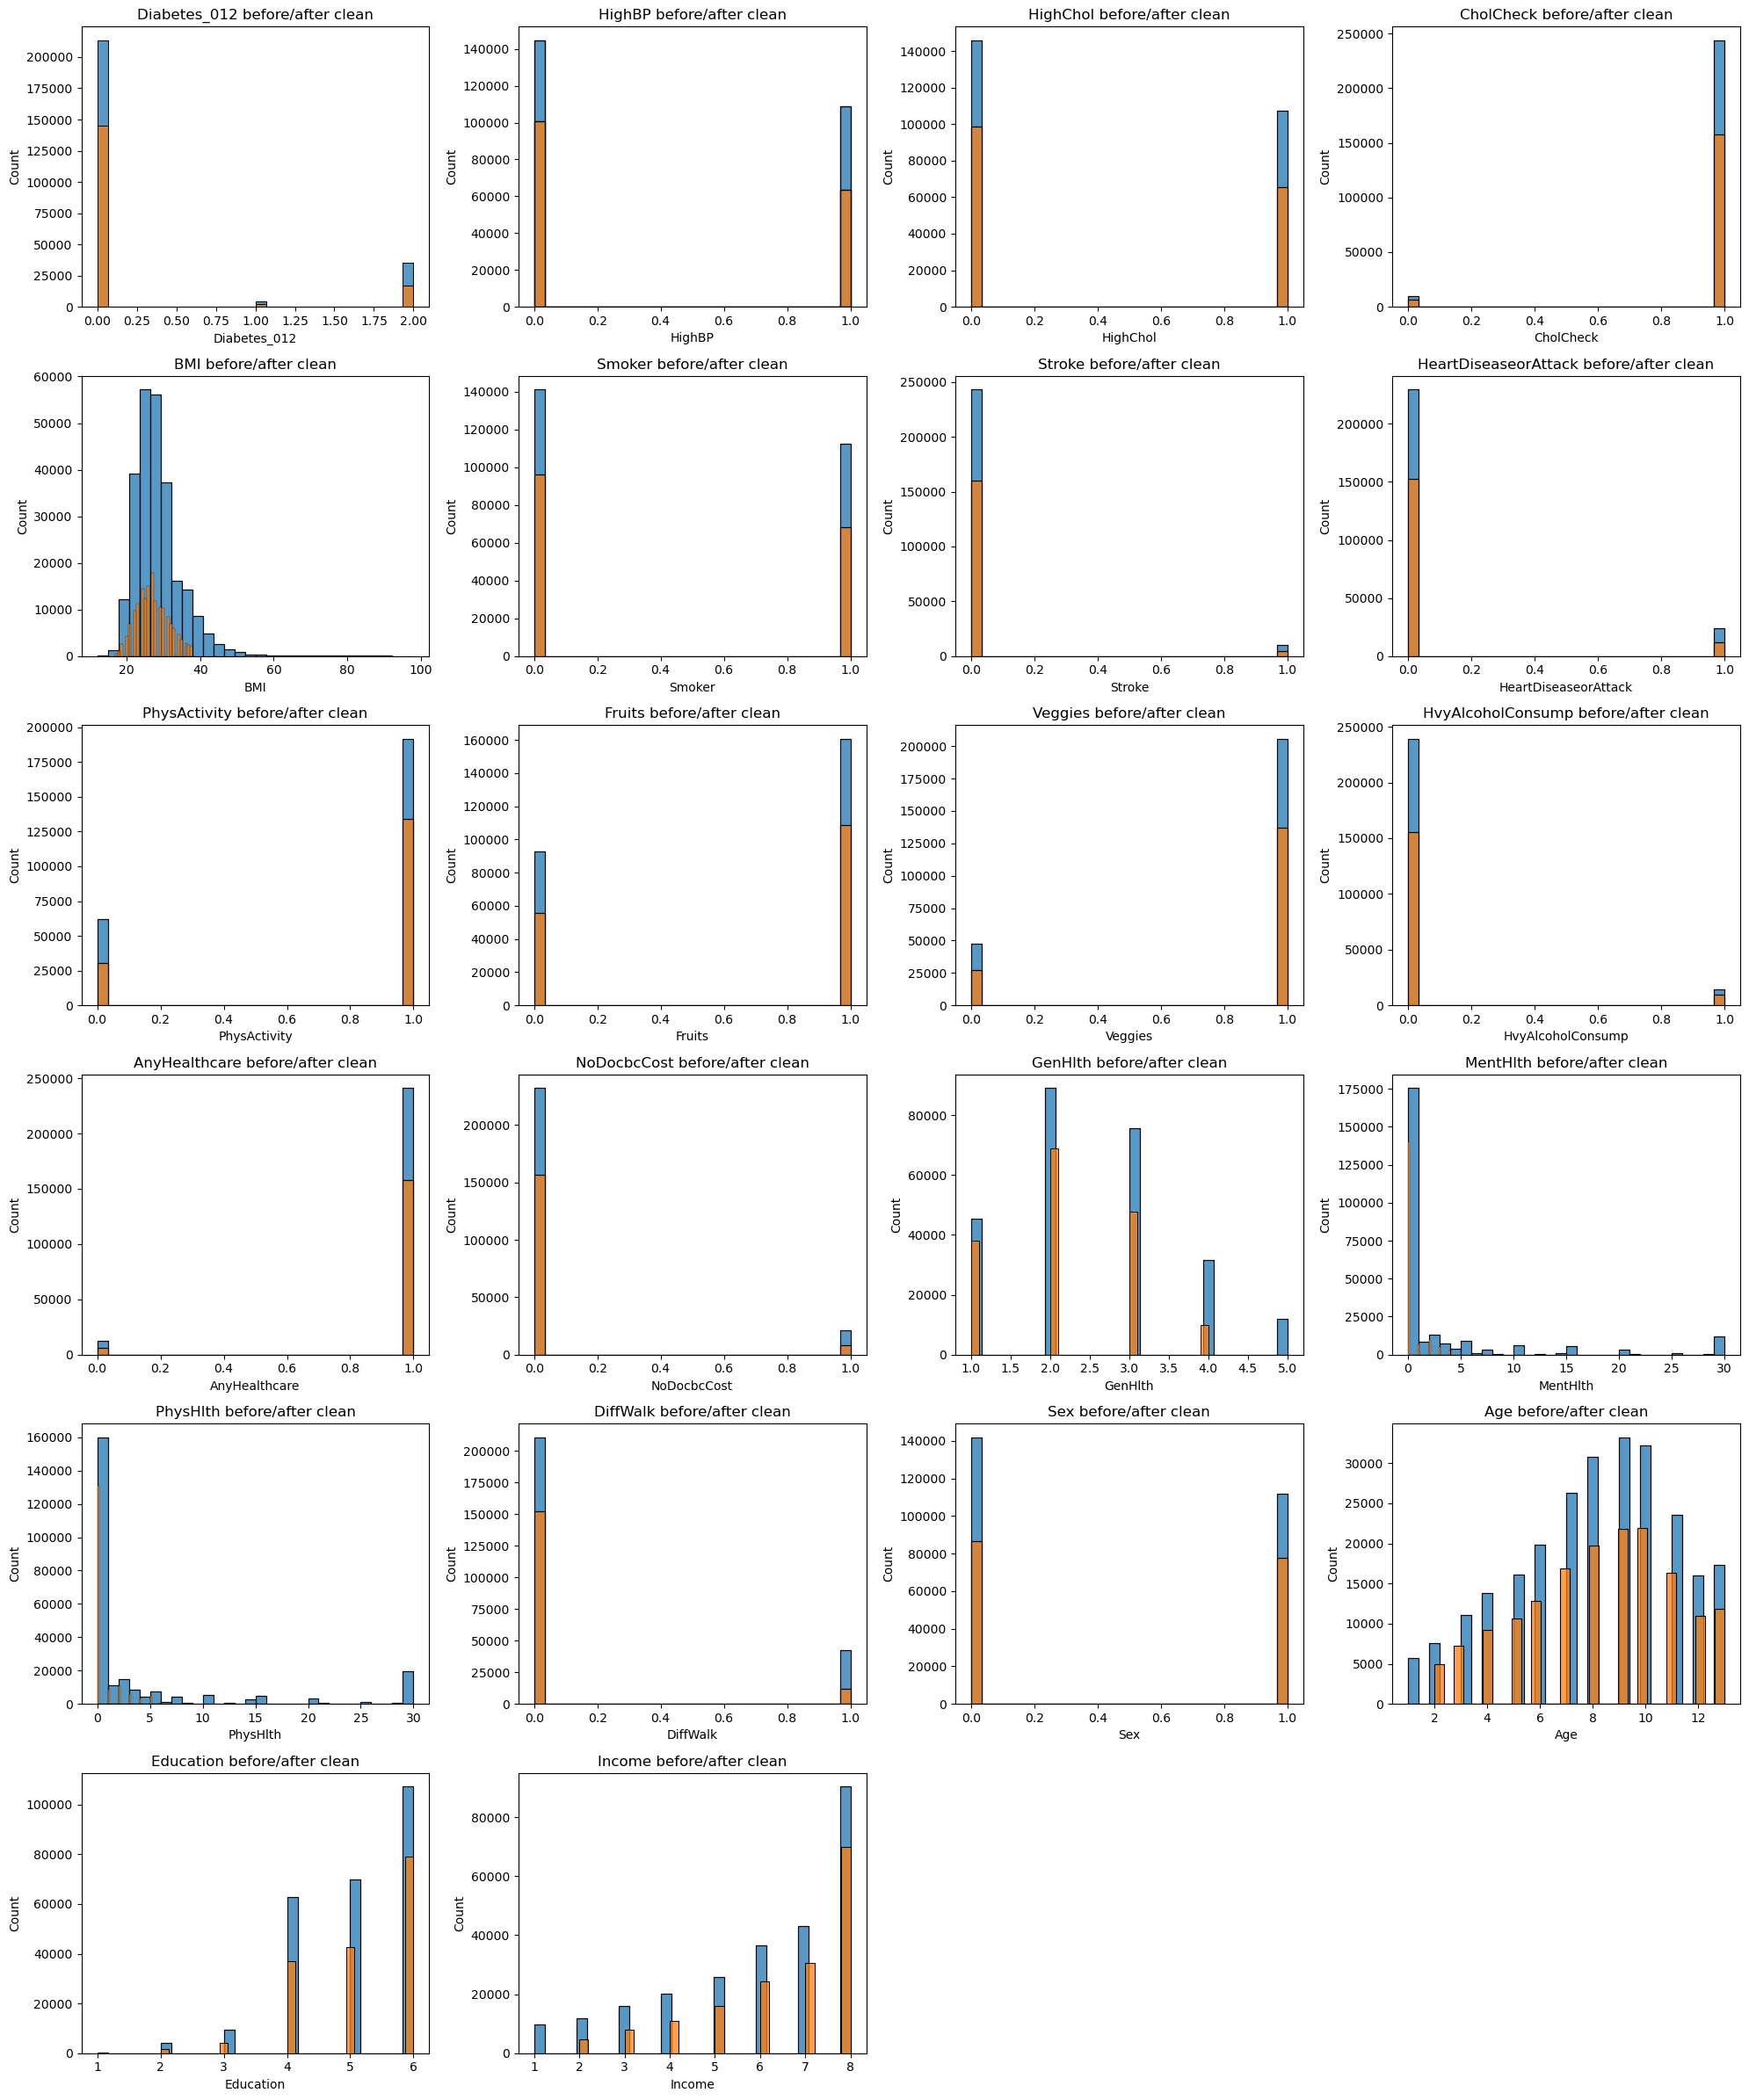

In [11]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col], bins=30, kde=False)
    plt.title(f"{col} before/after clean")
    
    plt.tight_layout()

plt.show()

In [16]:
# save the cleaned data:

df_clean.to_csv('cleaned_diabetes.csv', index=False)
